In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

In [2]:
# read customers and transactions data

customers = pd.read_csv(r'C:\Users\Nutzer\OneDrive\Desktop\viabill\customers.csv')
transactions = pd.read_csv(r'C:\Users\Nutzer\OneDrive\Desktop\viabill\transactions.csv')

# last available transaction of the client as a credit application
# select the last transaction (transactionID increases with time) for each customer in Transaction table

credit_applications = transactions.groupby(['customerID'], as_index=False).agg({'transactionID':'max'})

# join other related columns of transaction data
new_trans = credit_applications.merge(transactions[['transactionID','price', 'paytmentStatus1',
       'paytmentStatus2', 'paytmentStatus3', 'paytmentStatus4']], on='transactionID', how='left')

# Join transactions df with customers df on customerID
df = pd.merge(new_trans, customers, on='customerID', how='left')

# Replace missing Income values with 999

#df['income'] = df['income'].fillna(999)

#create “trans_price_avg_lst3” – for credit applications

df['trans_price_avg_lst3'] = df.groupby('customerID')['price'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
df

,customerID,transactionID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,sex,age,residentialAddress,postalAddress,income,trans_price_avg_lst3
0,1.0,1697842,147,0,0,0,0,1,25,28 Irvine Place,28 Irvine Place,NaN,147.0
1,2.0,1834257,150,0,0,0,0,1,19,72 Bertha Street,72 Bertha Street,43200.0,150.0
2,3.0,1974624,140,0,0,0,0,2,22,63 Ladberry Street,63 Ladberry Street,70200.0,140.0
3,4.0,1536291,136,0,1,0,0,0,24,98 Linneman Close,98 Linneman Close,93900.0,136.0
4,5.0,661121,181,0,0,0,0,1,53,56 Salonica Road,56 Salonica Road,77000.0,181.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
490528,499996.0,665043,27,0,0,0,0,1,68,95 Argyle Parade,95 Argyle Parade,40500.0,27.0
490529,499997.0,1756533,127,0,0,1,0,2,22,34 Bearke Place,34 Bearke Place,44900.0,127.0
490530,499998.0,1628579,157,0,0,0,0,1,27,95 Glenhurst Street,95 Glenhurst Street,48700.0,157.0
490531,499999.0,1722718,171,0,0,0,0,1,55,34 Kiandra Close,34 Kiandra Close,7600.0,171.0


In [3]:
# drop adress columns
# we could create region variable out of adresses in future

df.drop(columns=['residentialAddress', 'postalAddress'], axis=1, inplace=True)

# we have payment status for 4 weeks. i combined each row together in order to see behavior of customer at end of the month
df['combined'] = df['paytmentStatus1'].astype(str) + df['paytmentStatus2'].astype(str) + df['paytmentStatus3'].astype(str) + df['paytmentStatus4'].astype(str)

# got results as 0010, 0002 and etc.
df

,customerID,transactionID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,sex,age,income,trans_price_avg_lst3,combined
0,1.0,1697842,147,0,0,0,0,1,25,NaN,147.0,0000
1,2.0,1834257,150,0,0,0,0,1,19,43200.0,150.0,0000
2,3.0,1974624,140,0,0,0,0,2,22,70200.0,140.0,0000
3,4.0,1536291,136,0,1,0,0,0,24,93900.0,136.0,0100
4,5.0,661121,181,0,0,0,0,1,53,77000.0,181.0,0000
...,...,...,...,...,...,...,...,...,...,...,...,...
490528,499996.0,665043,27,0,0,0,0,1,68,40500.0,27.0,0000
490529,499997.0,1756533,127,0,0,1,0,2,22,44900.0,127.0,0010
490530,499998.0,1628579,157,0,0,0,0,1,27,48700.0,157.0,0000
490531,499999.0,1722718,171,0,0,0,0,1,55,7600.0,171.0,0000


In [4]:
# due to using WOE transformation i need binary values
# Hence in combination if there is 2 it will be not paid other cases paid
# In this version paid and paid but late will be considered as paid
# function to check for default
def check_default(combined):
    if '2' in combined:
        return 2
    else:
        return 0
    
# Apply function to create default column
df['default'] = df['combined'].apply(check_default)

df

,customerID,transactionID,price,paytmentStatus1,paytmentStatus2,paytmentStatus3,paytmentStatus4,sex,age,income,trans_price_avg_lst3,combined,default
0,1.0,1697842,147,0,0,0,0,1,25,NaN,147.0,0000,0
1,2.0,1834257,150,0,0,0,0,1,19,43200.0,150.0,0000,0
2,3.0,1974624,140,0,0,0,0,2,22,70200.0,140.0,0000,0
3,4.0,1536291,136,0,1,0,0,0,24,93900.0,136.0,0100,0
4,5.0,661121,181,0,0,0,0,1,53,77000.0,181.0,0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
490528,499996.0,665043,27,0,0,0,0,1,68,40500.0,27.0,0000,0
490529,499997.0,1756533,127,0,0,1,0,2,22,44900.0,127.0,0010,0
490530,499998.0,1628579,157,0,0,0,0,1,27,48700.0,157.0,0000,0
490531,499999.0,1722718,171,0,0,0,0,1,55,7600.0,171.0,0000,0


In [5]:
df['default'] = np.where(df['default']==2,1,df['default'])

In [6]:
df.drop(columns=['paytmentStatus1','paytmentStatus2', 'paytmentStatus3', 'paytmentStatus4','combined'],axis=1,inplace=True)

In [7]:
df['customerID'] = df['customerID'].astype(int)
df['customerID'] = df['customerID'].astype(str).str.zfill(7)
df['transactionID'] = df['transactionID'].astype(str)

df

# last version of data is as below. 
# CustomerID and TransactionID will not be used in modeling

,customerID,transactionID,price,sex,age,income,trans_price_avg_lst3,default
0,0000001,1697842,147,1,25,NaN,147.0,0
1,0000002,1834257,150,1,19,43200.0,150.0,0
2,0000003,1974624,140,2,22,70200.0,140.0,0
3,0000004,1536291,136,0,24,93900.0,136.0,0
4,0000005,661121,181,1,53,77000.0,181.0,0
...,...,...,...,...,...,...,...,...
490528,0499996,665043,27,1,68,40500.0,27.0,0
490529,0499997,1756533,127,2,22,44900.0,127.0,0
490530,0499998,1628579,157,1,27,48700.0,157.0,0
490531,0499999,1722718,171,1,55,7600.0,171.0,0


In [8]:
# change position of columns 

cols = ['customerID', 'transactionID', 'default', 'price', 'sex', 'age', 'income',
       'trans_price_avg_lst3']

df = df[cols]

df

,customerID,transactionID,default,price,sex,age,income,trans_price_avg_lst3
0,0000001,1697842,0,147,1,25,NaN,147.0
1,0000002,1834257,0,150,1,19,43200.0,150.0
2,0000003,1974624,0,140,2,22,70200.0,140.0
3,0000004,1536291,0,136,0,24,93900.0,136.0
4,0000005,661121,0,181,1,53,77000.0,181.0
...,...,...,...,...,...,...,...,...
490528,0499996,665043,0,27,1,68,40500.0,27.0
490529,0499997,1756533,0,127,2,22,44900.0,127.0
490530,0499998,1628579,0,157,1,27,48700.0,157.0
490531,0499999,1722718,0,171,1,55,7600.0,171.0


In [9]:
# Check if there is a dependency between age and sex in the data

from scipy.stats import pearsonr

corr, p_value = pearsonr(df['sex'], df['age'])
print('correlation coef: ',corr)
print('p value: ', p_value)

#we can conclude that there is a too very weak positive correlation between age and sex
# p value considered to be lower than 0.05, hence this correlation is statistically not significant at the 0.31 level.

correlation coef:  0.001435107992500123
p value:  0.3148391817015066


In [10]:
from optbinning import OptimalBinning
import math

(CVXPY) Mar 23 08:52:44 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 23 08:52:44 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [11]:
numer_vl = df.iloc[:,3:]
numer_vl

,price,sex,age,income,trans_price_avg_lst3
0,147,1,25,NaN,147.0
1,150,1,19,43200.0,150.0
2,140,2,22,70200.0,140.0
3,136,0,24,93900.0,136.0
4,181,1,53,77000.0,181.0
...,...,...,...,...,...
490528,27,1,68,40500.0,27.0
490529,127,2,22,44900.0,127.0
490530,157,1,27,48700.0,157.0
490531,171,1,55,7600.0,171.0



 var:  price


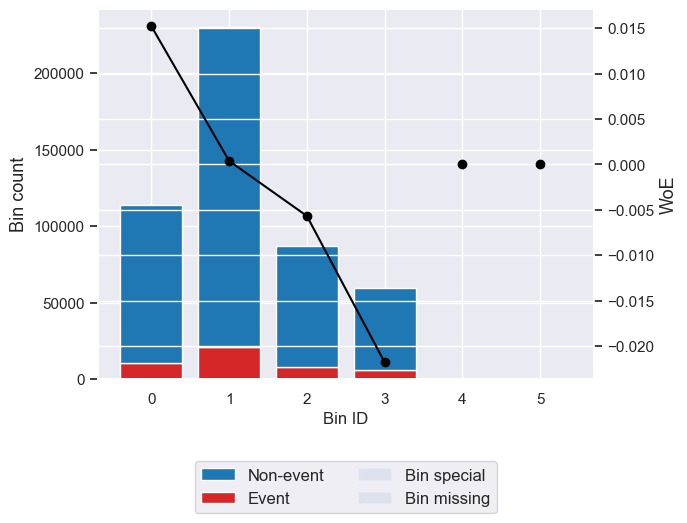


 BINNING TABLE:  
                      Bin   Count  Count (%)  Non-event  Event  Event rate  \
0          (-inf, 48.50)  113682   0.231752     103368  10314    0.090727   
1        [48.50, 141.50)  230178   0.469241     209011  21167    0.091959   
2       [141.50, 176.50)   86820   0.176991      78792   8028    0.092467   
3          [176.50, inf)   59853   0.122016      54237   5616    0.093830   
4                Special       0   0.000000          0      0    0.000000   
5                Missing       0   0.000000          0      0    0.000000   
Totals                    490533   1.000000     445408  45125    0.091992   

             WoE            IV            JS  
0       0.015239  5.348510e-05  6.685573e-06  
1       0.000389  7.107414e-08  8.884268e-09  
2      -0.005678  5.719901e-06  7.149866e-07  
3      -0.021811  5.856241e-05  7.320156e-06  
4            0.0  0.000000e+00  0.000000e+00  
5            0.0  0.000000e+00  0.000000e+00  
Totals            1.178385e-04  1.

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_11332\3278070464.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optb_bin_iv_js = optb_bin_iv_js.append({'var': i, 'iv': float(bin_tbl[-1:]['IV'])}, ignore_index=True)


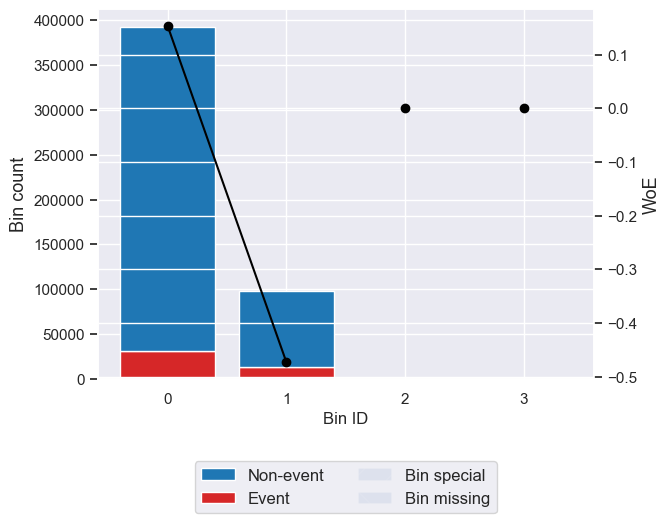


 BINNING TABLE:  
                  Bin   Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 1.50)  392079   0.799292     360728  31351    0.079961   
1        [1.50, inf)   98454   0.200708      84680  13774    0.139903   
2            Special       0   0.000000          0      0    0.000000   
3            Missing       0   0.000000          0      0    0.000000   
Totals                490533   1.000000     445408  45125    0.091992   

             WoE        IV        JS  
0       0.153324  0.017651  0.002204  
1      -0.473458  0.054506  0.006750  
2            0.0  0.000000  0.000000  
3            0.0  0.000000  0.000000  
Totals            0.072157  0.008955  

 SPLITS:  [-inf, 1.5, inf]

 WOE 
 [0.15332374784461145 -0.473457610247787 0.0]

 ----------------------------------------- 


 var:  age


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_11332\3278070464.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optb_bin_iv_js = optb_bin_iv_js.append({'var': i, 'iv': float(bin_tbl[-1:]['IV'])}, ignore_index=True)


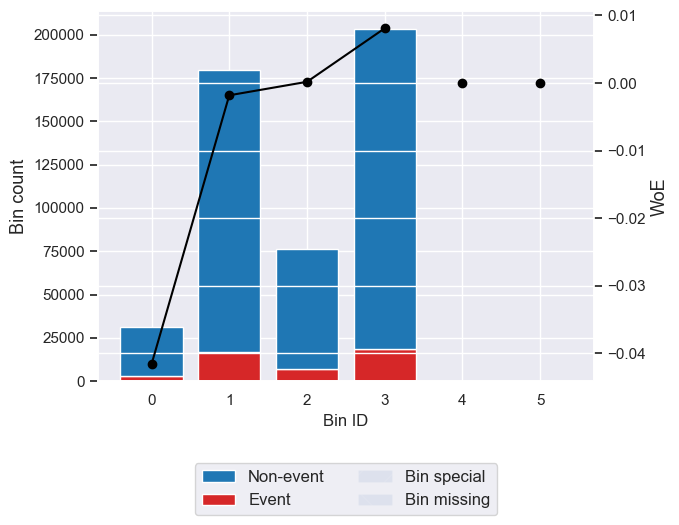


 BINNING TABLE:  
                    Bin   Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 20.50)   31478   0.064171      28471   3007    0.095527   
1       [20.50, 46.50)  179634   0.366202     163082  16552    0.092143   
2       [46.50, 52.50)   76074   0.155084      69077   6997    0.091976   
3         [52.50, inf)  203347   0.414543     184778  18569    0.091317   
4              Special       0   0.000000          0      0    0.000000   
5              Missing       0   0.000000          0      0    0.000000   
Totals                  490533   1.000000     445408  45125    0.091992   

             WoE            IV            JS  
0      -0.041611  1.130139e-04  1.412572e-05  
1      -0.001808  1.198077e-06  1.497596e-07  
2       0.000186  5.367157e-09  6.708946e-10  
3       0.008107  2.715710e-05  3.394629e-06  
4            0.0  0.000000e+00  0.000000e+00  
5            0.0  0.000000e+00  0.000000e+00  
Totals            1.413744e-04  1.767078e-05  

 S

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_11332\3278070464.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optb_bin_iv_js = optb_bin_iv_js.append({'var': i, 'iv': float(bin_tbl[-1:]['IV'])}, ignore_index=True)


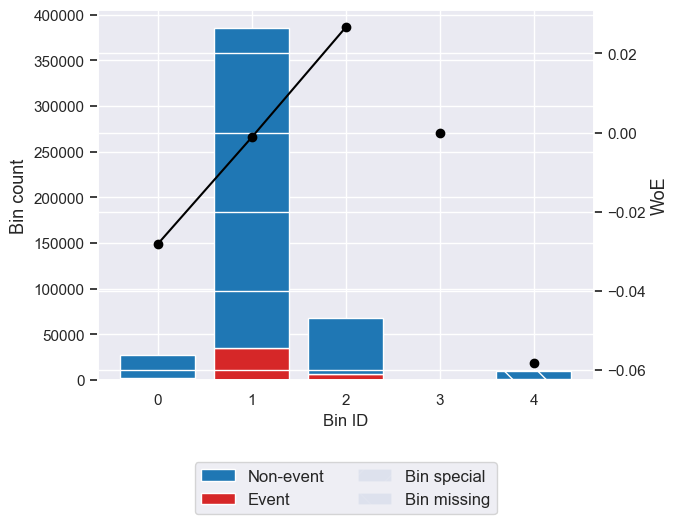


 BINNING TABLE:  
                         Bin   Count  Count (%)  Non-event  Event  Event rate  \
0           (-inf, 5550.00)   26927   0.054893      24386   2541    0.094366   
1       [5550.00, 85850.00)  385452   0.785782     349956  35496    0.092089   
2           [85850.00, inf)   68368   0.139375      62229   6139    0.089793   
3                   Special       0   0.000000          0      0    0.000000   
4                   Missing    9786   0.019950       8837    949    0.096975   
Totals                       490533   1.000000     445408  45125    0.091992   

             WoE        IV            JS  
0      -0.028103  0.000044  5.481437e-06  
1      -0.001167  0.000001  1.338049e-07  
2       0.026605  0.000098  1.219813e-05  
3            0.0  0.000000  0.000000e+00  
4       -0.05826  0.000069  8.666712e-06  
Totals            0.000212  2.648008e-05  

 SPLITS:  [-inf, 5550.0, 85850.0, inf]

 WOE 
 [-0.028102806591898677 -0.0011668811735110474 0.026604967194813867
 -0

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_11332\3278070464.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optb_bin_iv_js = optb_bin_iv_js.append({'var': i, 'iv': float(bin_tbl[-1:]['IV'])}, ignore_index=True)


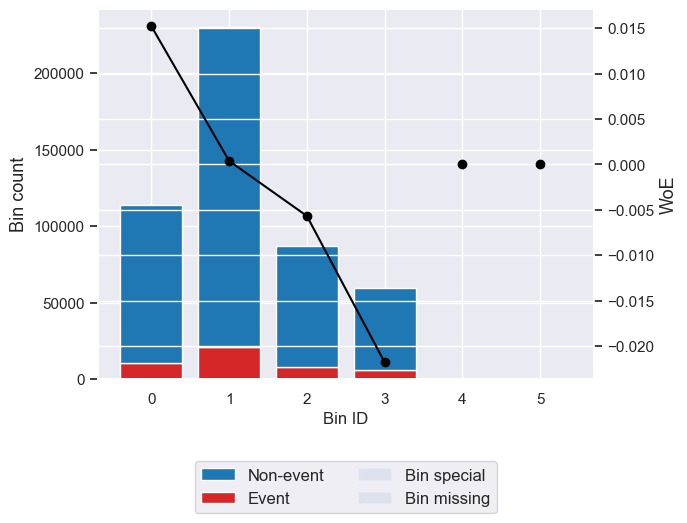


 BINNING TABLE:  
                      Bin   Count  Count (%)  Non-event  Event  Event rate  \
0          (-inf, 48.50)  113682   0.231752     103368  10314    0.090727   
1        [48.50, 141.50)  230178   0.469241     209011  21167    0.091959   
2       [141.50, 176.50)   86820   0.176991      78792   8028    0.092467   
3          [176.50, inf)   59853   0.122016      54237   5616    0.093830   
4                Special       0   0.000000          0      0    0.000000   
5                Missing       0   0.000000          0      0    0.000000   
Totals                    490533   1.000000     445408  45125    0.091992   

             WoE            IV            JS  
0       0.015239  5.348510e-05  6.685573e-06  
1       0.000389  7.107414e-08  8.884268e-09  
2      -0.005678  5.719901e-06  7.149866e-07  
3      -0.021811  5.856241e-05  7.320156e-06  
4            0.0  0.000000e+00  0.000000e+00  
5            0.0  0.000000e+00  0.000000e+00  
Totals            1.178385e-04  1.

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_11332\3278070464.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optb_bin_iv_js = optb_bin_iv_js.append({'var': i, 'iv': float(bin_tbl[-1:]['IV'])}, ignore_index=True)


In [12]:
y = df['default'].values.astype('float')

data_bin_optb = pd.DataFrame()
optb_bin_iv_js = pd.DataFrame(columns = ['var', 'iv']) 

data_bin_optb['y'] = y

d_splits = dict()
d_woe = dict()


for i in numer_vl: 
    
    
    print('\n', "var: ", i)

    x = df[i].values.astype('float') 
    
    
    optb = OptimalBinning(dtype="numerical", solver="cp"
                          , divergence = 'iv' 
                          , max_n_bins= 5  
                          
                          , min_bin_size = 0.05 
                          
                          , min_bin_n_nonevent = 1
                          , min_bin_n_event = 1 
                          
                          , monotonic_trend = 'auto_asc_desc' 
                           )
    optb.fit(x, y)
    
    
    binning_table = optb.binning_table
    type(binning_table)
    bin_tbl = pd.DataFrame(binning_table.build())

    binning_table.plot(metric="woe")

    print('\n', "BINNING TABLE: ", '\n', bin_tbl)
    

    optb_bin_iv_js = optb_bin_iv_js.append({'var': i, 'iv': float(bin_tbl[-1:]['IV'])}, ignore_index=True)

    arr = optb.splits 
    arr = [-math.inf, *arr]
    arr = [*arr, math.inf]
    print('\n', "SPLITS: ", arr) 

    d_splits[i] = arr
    
    
    woe_list = bin_tbl['WoE'].head(len(arr)-1)
    woe_list = np.concatenate((woe_list, [float(bin_tbl[-2:-1]['WoE'])]))
    
    d_woe[i] = woe_list
    
    
    print('\n', "WOE", '\n', woe_list)

    binned_column = []
    binned_column = pd.cut(x, bins = arr, labels = bin_tbl['WoE'].head(len(arr)-1))    
    binned_column = binned_column.add_categories(float(bin_tbl[-2:-1]['WoE'])).fillna(float(bin_tbl[-2:-1]['WoE']))
    data_bin_optb[i] = binned_column
    
    
    print('\n', '-----------------------------------------', '\n')

bin_arrays = pd.DataFrame.from_dict(d_splits, orient='index').transpose()
woe_arrays = pd.DataFrame.from_dict(d_woe, orient='index').transpose()


In [13]:
bin_arrays

,price,sex,age,income,trans_price_avg_lst3
0,-inf,-inf,-inf,-inf,-inf
1,48.5,1.5,20.5,5550.0,48.5
2,141.5,inf,46.5,85850.0,141.5
3,176.5,NaN,52.5,inf,176.5
4,inf,NaN,inf,NaN,inf


In [14]:
woe_arrays

,price,sex,age,income,trans_price_avg_lst3
0,0.015239,0.153324,-0.041611,-0.028103,0.015239
1,0.000389,-0.473458,-0.001808,-0.001167,0.000389
2,-0.005678,0.000000,0.000186,0.026605,-0.005678
3,-0.021811,NaN,0.008107,-0.058260,-0.021811
4,0.000000,NaN,0.000000,NaN,0.000000


In [15]:
# replace normal values with woe values

fl=df.iloc[:, 3:]
data_full_binned = df.iloc[:, :3]

for i in fl:
    print(i)
    binned_column = []       
    binned_column = pd.cut(df[i].astype('float')
                           , bins = bin_arrays[i].dropna()
                           , labels = woe_arrays[:len(bin_arrays[i].dropna())-1][i]
                          )   

    if binned_column.isnull().values.any():
        
        binned_column = binned_column.cat.add_categories(float(woe_arrays[i].dropna().tail(1))).fillna(float(woe_arrays[i].dropna().tail(1)))

    data_full_binned[i] = binned_column
    print('\n', '-----------------------')
   

price

 -----------------------
sex

 -----------------------
age

 -----------------------
income

 -----------------------
trans_price_avg_lst3

 -----------------------


In [16]:
data_full_binned

# Now we got df with woe transformed values

,customerID,transactionID,default,price,sex,age,income,trans_price_avg_lst3
0,0000001,1697842,0,-0.005678,0.153324,-0.001808,-0.058260,-0.005678
1,0000002,1834257,0,-0.005678,0.153324,-0.041611,-0.001167,-0.005678
2,0000003,1974624,0,0.000389,-0.473458,-0.001808,-0.001167,0.000389
3,0000004,1536291,0,0.000389,0.153324,-0.001808,0.026605,0.000389
4,0000005,661121,0,-0.021811,0.153324,0.008107,-0.001167,-0.021811
...,...,...,...,...,...,...,...,...
490528,0499996,665043,0,0.015239,0.153324,0.008107,-0.001167,0.015239
490529,0499997,1756533,0,0.000389,-0.473458,-0.001808,-0.001167,0.000389
490530,0499998,1628579,0,-0.005678,0.153324,-0.001808,-0.001167,-0.005678
490531,0499999,1722718,0,-0.005678,0.153324,0.008107,-0.001167,-0.005678


In [17]:
cols_to_convert = ['price', 'sex', 'age', 'income','trans_price_avg_lst3']

for col in cols_to_convert:
    data_full_binned[col] = data_full_binned[col].astype(float)


In [18]:
# checking with all independent variables
# due to less amount of features i dont want to use feature importance and lower it. 

X = data_full_binned[[ 'price', 'sex', 'age', 'income','trans_price_avg_lst3']]
y = data_full_binned[['default']]

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt

In [21]:
# some of the models i consider to use

models = [LogisticRegression(),XGBClassifier(),LGBMClassifier(),RandomForestClassifier(), LogisticRegression(class_weight='balanced')]

C:\Users\Nutzer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Performance for LogisticRegression()
[[133615      0]
 [ 13545      0]]


C:\Users\Nutzer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nutzer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nutzer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    133615
           1       0.00      0.00      0.00     13545

    accuracy                           0.91    147160
   macro avg       0.45      0.50      0.48    147160
weighted avg       0.82      0.91      0.86    147160

                                      
AUC Score: 56.273681841572575
Gini prob is 12.547363683145152


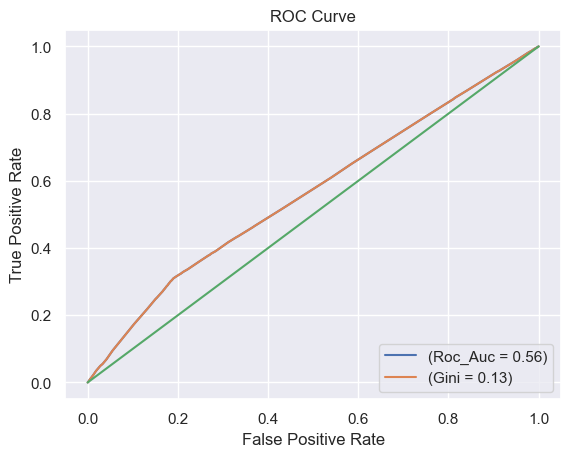

                                      
Model Performance for XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)
[[133615      0]
 [ 13545      0]]


C:\Users\Nutzer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nutzer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nutzer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    133615
           1       0.00      0.00      0.00     13545

    accuracy                           0.91    147160
   macro avg       0.45      0.50      0.48    147160
weighted avg       0.82      0.91      0.86    147160

                                      
AUC Score: 56.07081858510773
Gini prob is 12.141637170215457


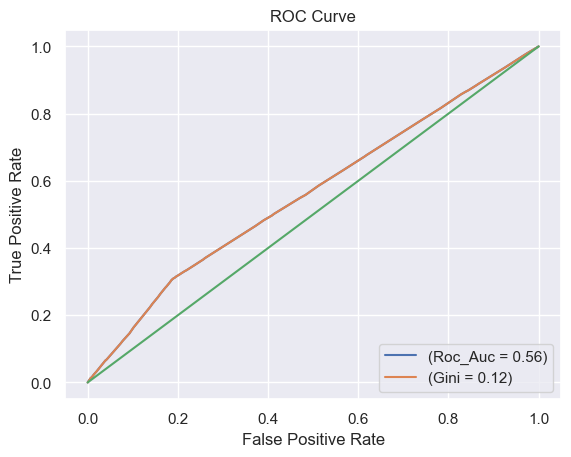

C:\Users\Nutzer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Nutzer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Performance for LGBMClassifier()
[[133615      0]
 [ 13545      0]]


C:\Users\Nutzer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nutzer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nutzer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    133615
           1       0.00      0.00      0.00     13545

    accuracy                           0.91    147160
   macro avg       0.45      0.50      0.48    147160
weighted avg       0.82      0.91      0.86    147160

                                      
AUC Score: 56.10984207268568
Gini prob is 12.219684145371357


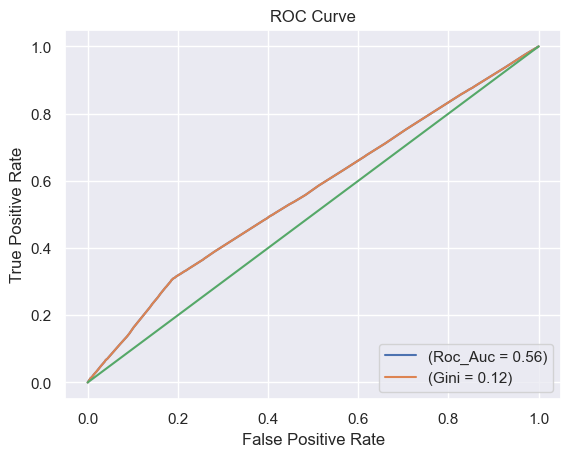

C:\Users\Nutzer\AppData\Local\Temp\ipykernel_11332\595111715.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  models.fit(X_train, y_train)


Model Performance for RandomForestClassifier()
[[133615      0]
 [ 13545      0]]


C:\Users\Nutzer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nutzer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nutzer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    133615
           1       0.00      0.00      0.00     13545

    accuracy                           0.91    147160
   macro avg       0.45      0.50      0.48    147160
weighted avg       0.82      0.91      0.86    147160

                                      
AUC Score: 56.13388590909567
Gini prob is 12.267771818191342


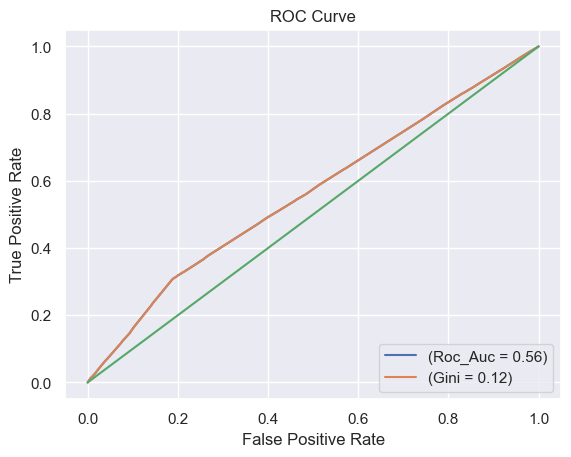

C:\Users\Nutzer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model Performance for LogisticRegression(class_weight='balanced')
[[108224  25391]
 [  9348   4197]]
              precision    recall  f1-score   support

           0       0.92      0.81      0.86    133615
           1       0.14      0.31      0.19     13545

    accuracy                           0.76    147160
   macro avg       0.53      0.56      0.53    147160
weighted avg       0.85      0.76      0.80    147160

                                      
AUC Score: 56.27277572694682
Gini prob is 12.545551453893644


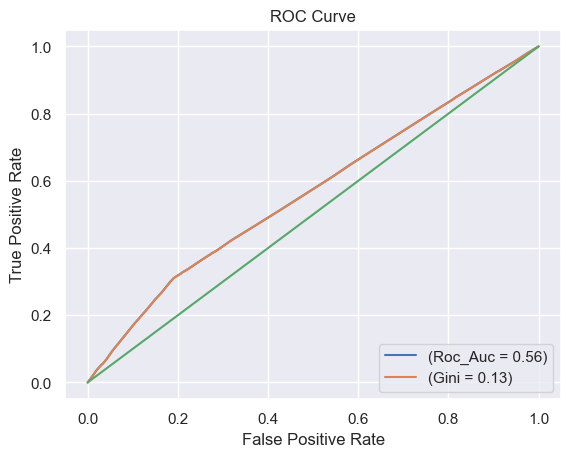

In [22]:
# Building a loop where all performance measures will be calculated for each ML model

# Confusion matrix
# Classification table
# Roc_auc_score
# Gini coefficient
# Roc curve


for i in models:
    models=i
    models.fit(X_train, y_train)
    
    y_pred = models.predict(X_test)
    y_prob = models.predict_proba(X_test)[:,1]


    roc_prob = roc_auc_score(y_test, y_prob)
    
    gini_prob = roc_prob*2-1
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.figure()
    
    plt.plot(fpr, tpr, label='(Roc_Auc = %0.2f)' % roc_prob)
    plt.plot(fpr, tpr, label='(Gini = %0.2f)' % gini_prob)
    plt.plot([0, 1], [0, 1])
    plt.xlim()
    plt.ylim()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    
    
    print('Model Performance for',i)    
   
    print(confusion_matrix)
    print(classification_report(y_test, y_pred))
    print("                                      ")
    print('AUC Score:', roc_auc_score(y_test, y_prob)*100)
    print('Gini prob is', gini_prob*100)
    plt.show()
    print("="*70)
    print("                                      ")

## Let us consider univariate gini for each feature too and see which variable gives us best gini

In [28]:
development = X_train.join(y_train)
development['tag'] = 'DEV'
development

,price,sex,age,income,trans_price_avg_lst3,default,tag
180991,-0.005678,0.153324,0.000186,-0.001167,-0.005678,1,DEV
426265,-0.005678,0.153324,-0.001808,-0.001167,-0.005678,0,DEV
456227,-0.021811,0.153324,0.000186,-0.028103,-0.021811,0,DEV
219405,-0.005678,0.153324,-0.001808,-0.001167,-0.005678,0,DEV
469171,0.000389,0.153324,-0.001808,-0.001167,0.000389,0,DEV
...,...,...,...,...,...,...,...
259178,-0.005678,0.153324,0.008107,-0.001167,-0.005678,0,DEV
365838,0.000389,-0.473458,-0.041611,-0.001167,0.000389,1,DEV
131932,0.015239,-0.473458,0.008107,-0.001167,0.015239,1,DEV
146867,0.015239,0.153324,-0.001808,-0.028103,0.015239,0,DEV


In [30]:
validation = X_test.join(y_test)
validation['tag'] = 'VAL'
validation

,price,sex,age,income,trans_price_avg_lst3,default,tag
155664,-0.005678,0.153324,-0.001808,-0.001167,-0.005678,0,VAL
108339,0.015239,0.153324,0.000186,-0.001167,0.015239,0,VAL
194854,0.000389,0.153324,-0.001808,-0.001167,0.000389,0,VAL
53680,0.015239,0.153324,0.008107,-0.001167,0.015239,0,VAL
430837,0.000389,0.153324,-0.001808,-0.001167,0.000389,0,VAL
...,...,...,...,...,...,...,...
80515,0.000389,0.153324,-0.001808,-0.001167,0.000389,0,VAL
326730,-0.005678,-0.473458,0.008107,-0.001167,-0.005678,1,VAL
427533,0.000389,0.153324,0.000186,-0.001167,0.000389,0,VAL
394268,0.000389,0.153324,0.008107,-0.001167,0.000389,0,VAL


In [32]:
ls=[development,validation]
data_full = pd.concat(ls,axis=0)

In [33]:
data_full

# concat splitted data and added tag column in order to recognize splits

,price,sex,age,income,trans_price_avg_lst3,default,tag
180991,-0.005678,0.153324,0.000186,-0.001167,-0.005678,1,DEV
426265,-0.005678,0.153324,-0.001808,-0.001167,-0.005678,0,DEV
456227,-0.021811,0.153324,0.000186,-0.028103,-0.021811,0,DEV
219405,-0.005678,0.153324,-0.001808,-0.001167,-0.005678,0,DEV
469171,0.000389,0.153324,-0.001808,-0.001167,0.000389,0,DEV
...,...,...,...,...,...,...,...
80515,0.000389,0.153324,-0.001808,-0.001167,0.000389,0,VAL
326730,-0.005678,-0.473458,0.008107,-0.001167,-0.005678,1,VAL
427533,0.000389,0.153324,0.000186,-0.001167,0.000389,0,VAL
394268,0.000389,0.153324,0.008107,-0.001167,0.000389,0,VAL


In [35]:
vars_list = ['price', 'sex', 'age', 'income','trans_price_avg_lst3']

In [45]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

# univariate gini will be calculated for each independent feature vs target variable in a loop

In [46]:
gini_dev = pd.DataFrame(columns = ('var', 'gini'))
print('development')
for i in range(len(vars_list)):

    x = data_full[data_full['tag'] == 'DEV'][[vars_list[i]]]
    y_train = data_full[data_full['tag'] == 'DEV']['default']

    logreg.fit(x, y_train)
    y_pred = logreg.predict_proba(x)[:,1]
    gini_dev.loc[i] = [vars_list[i], 2*metrics.roc_auc_score(y_train, y_pred)-1]
gini_dev

development


,var,gini
0,price,0.004493
1,sex,0.113107
2,age,0.005608
3,income,0.005737
4,trans_price_avg_lst3,0.004493


In [40]:
gini_val = pd.DataFrame(columns = ('var', 'gini'))
print('validation')
for i in range(len(vars_list)):

    x = data_full[data_full['tag'] == 'VAL'][[vars_list[i]]]
    y_train = data_full[data_full['tag'] == 'VAL']['default']

    logreg.fit(x, y_train)
    y_pred = logreg.predict_proba(x)[:,1]
    gini_val.loc[i] = [vars_list[i], 2*metrics.roc_auc_score(y_train, y_pred)-1]
    
gini_val

validation


,var,gini
0,price,0.008329
1,sex,0.119825
2,age,0.003044
3,income,0.005929
4,trans_price_avg_lst3,0.008329


In [42]:
gini_dev_val = gini_dev.merge(gini_val,on='var',how='left')
gini_dev_val = gini_dev_val.rename(columns = {'gini_x':'DEV_gini','gini_y':'VAL_gini'})

gini_dev_val

,var,DEV_gini,VAL_gini
0,price,0.004493,0.008329
1,sex,0.113107,0.119825
2,age,0.005608,0.003044
3,income,0.005737,0.005929
4,trans_price_avg_lst3,0.004493,0.008329


In [ ]:
# gender feature has best gini among others